In [1]:
SEED = 2023
TDDPM_DIR = "/home/liu00980/Documents/multimodal/tabular/tab-ddpm/"
SYNINF_DIR = (
    "/home/liu00980/Documents/multimodal/tabular/tab-ddpm/pass-inference/syninf"
)

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import quantile_transform


import os
from tqdm import tqdm
import json
import pickle

import matplotlib.pyplot as plt

from sample import TrueSampler


import sys

sys.path.insert(0, SYNINF_DIR)

from utils_syninf import (
    train_tabddpm,
    generate_sample,
    concat_data,
    catboost_pred_model,
    test_rmse,
)
from utils_num import wasserstein_2_distance
from utils_viz import compare_distributions_grid, heatmap_correlation

# Get original data and pre-training data ready
* Original data: 500 training + 200 validation
* Pre-training sizes for ablation study: $n_h = 1000, 5000$ + **SAME** validation set
* An independent evaluation data of size 1000 is used for evaluation (only used at the end of everything)

In [3]:
sigma = 0.2
n_pretrain = 5000  # pre-training size
keyword = f"reg_{n_pretrain}"
synthetic_sample_dir = f"./ckpt/{keyword}/"


n_train = 500  # raw training size
n_val = 200  # validation size
n_test = 1000  # test or evaluation size

In [4]:
true_sampler = TrueSampler(sigma=sigma)

np.random.seed(SEED)

X_pretrain, y_pretrain = true_sampler.sample(n_pretrain)
X_train, y_train = true_sampler.sample(n_train)
X_val, y_val = true_sampler.sample(n_val)
X_test, y_test = true_sampler.sample(n_test)


raw_data_dir = os.path.join(TDDPM_DIR, f"data/reg_raw")
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)

    print(f"Saving raw data to {raw_data_dir} ...")

    np.save(os.path.join(raw_data_dir, "X_num_train.npy"), X_train)
    np.save(os.path.join(raw_data_dir, "y_train.npy"), y_train)

    np.save(os.path.join(raw_data_dir, "X_num_val.npy"), X_val)
    np.save(os.path.join(raw_data_dir, "y_val.npy"), y_val)

    np.save(os.path.join(raw_data_dir, "X_num_test.npy"), X_test)
    np.save(os.path.join(raw_data_dir, "y_test.npy"), y_test)

    info_dict = {
        "task_type": "regression",
        "name": "reg_raw",
        "id": "reg_raw",
        "train_size": n_train,
        "val_size": n_val,
        "test_size": n_test,
        "n_num_features": X_test.shape[1],
    }
    print(f"Saving raw dataset meta information to {raw_data_dir} ...")
    json.dump(info_dict, open(os.path.join(raw_data_dir, "info.json"), "w"))
else:
    print(
        f"Raw data information already exists in {raw_data_dir}, use existing validation and test set."
    )

    # use the same validation and test set in the pre-training configuration
    X_val = np.load(os.path.join(raw_data_dir, "X_num_val.npy"))
    y_val = np.load(os.path.join(raw_data_dir, "y_val.npy"))
    X_test = np.load(os.path.join(raw_data_dir, "X_num_test.npy"))
    y_test = np.load(os.path.join(raw_data_dir, "y_test.npy"))


pretrain_data_dir = os.path.join(TDDPM_DIR, f"data/reg_{n_pretrain}")
if not os.path.exists(pretrain_data_dir):
    os.makedirs(pretrain_data_dir)

    print(f"Saving pre-training data to {pretrain_data_dir} ...")

    np.save(os.path.join(pretrain_data_dir, "X_num_train.npy"), X_pretrain)
    np.save(os.path.join(pretrain_data_dir, "y_train.npy"), y_pretrain)

    np.save(os.path.join(pretrain_data_dir, "X_num_val.npy"), X_val)
    np.save(os.path.join(pretrain_data_dir, "y_val.npy"), y_val)

    np.save(os.path.join(pretrain_data_dir, "X_num_test.npy"), X_test)
    np.save(os.path.join(pretrain_data_dir, "y_test.npy"), y_test)

    info_dict = {
        "task_type": "regression",
        "name": f"reg_{n_pretrain}",
        "id": f"reg_{n_pretrain}",
        "train_size": n_pretrain,
        "val_size": n_val,
        "test_size": n_test,
        "n_num_features": X_test.shape[1],
    }
    print(f"Saving pre-training dataset meta information to {pretrain_data_dir} ...")
    json.dump(info_dict, open(os.path.join(pretrain_data_dir, "info.json"), "w"))
else:
    print(f"Pre-training data information already exists in {pretrain_data_dir}")

X shape:  (5000, 7)
y shape:  (5000,)
X shape:  (500, 7)
y shape:  (500,)
X shape:  (200, 7)
y shape:  (200,)
X shape:  (1000, 7)
y shape:  (1000,)
Raw data information already exists in /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/reg_raw, use existing validation and test set.
Pre-training data information already exists in /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/reg_5000


# Get the pre-trained generator

In [32]:
train_tabddpm(
    pipeline_config_path="./ckpt/base_config.toml",
    real_data_dir=os.path.join(TDDPM_DIR, f"data/{keyword}"),
    steps=50000,
    temp_parent_dir=synthetic_sample_dir,
    device="cuda:0",
)

Use category sizes from the training set: [0]
8
{'d_in': 8, 'num_classes': 0, 'is_y_cond': False, 'rtdl_params': {'d_layers': [512, 256, 256, 256, 256, 128], 'dropout': 0.0}}
mlp
Step 500/50000 MLoss: 0.0 GLoss: 0.4767 Sum: 0.4767
Step 1000/50000 MLoss: 0.0 GLoss: 0.4761 Sum: 0.4761
Step 1500/50000 MLoss: 0.0 GLoss: 0.4741 Sum: 0.4741
Step 2000/50000 MLoss: 0.0 GLoss: 0.4713 Sum: 0.4713
Step 2500/50000 MLoss: 0.0 GLoss: 0.4742 Sum: 0.4742
Step 3000/50000 MLoss: 0.0 GLoss: 0.4725 Sum: 0.4725
Step 3500/50000 MLoss: 0.0 GLoss: 0.469 Sum: 0.469
Step 4000/50000 MLoss: 0.0 GLoss: 0.4711 Sum: 0.4711
Step 4500/50000 MLoss: 0.0 GLoss: 0.4688 Sum: 0.4688
Step 5000/50000 MLoss: 0.0 GLoss: 0.4688 Sum: 0.4688
Step 5500/50000 MLoss: 0.0 GLoss: 0.4675 Sum: 0.4675
Step 6000/50000 MLoss: 0.0 GLoss: 0.4672 Sum: 0.4672
Step 6500/50000 MLoss: 0.0 GLoss: 0.4639 Sum: 0.4639
Step 7000/50000 MLoss: 0.0 GLoss: 0.4628 Sum: 0.4628
Step 7500/50000 MLoss: 0.0 GLoss: 0.4645 Sum: 0.4645
Step 8000/50000 MLoss: 0.0 GL

'./ckpt/reg_5000/'

## Visually check the performance of pre-trained generator

In [33]:
generate_sample(
    pipeline_config_path=f"./ckpt/{keyword}/config.toml",
    ckpt_path=f"./ckpt/{keyword}/model.pt",
    num_samples=10000,
    batch_size=10000,
    temp_parent_dir=synthetic_sample_dir,
)

Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (10000, 7)


'./ckpt/reg_5000/'

In [34]:
true_df = concat_data(pretrain_data_dir, split="train")
synthetic_df = concat_data(synthetic_sample_dir, split="train")

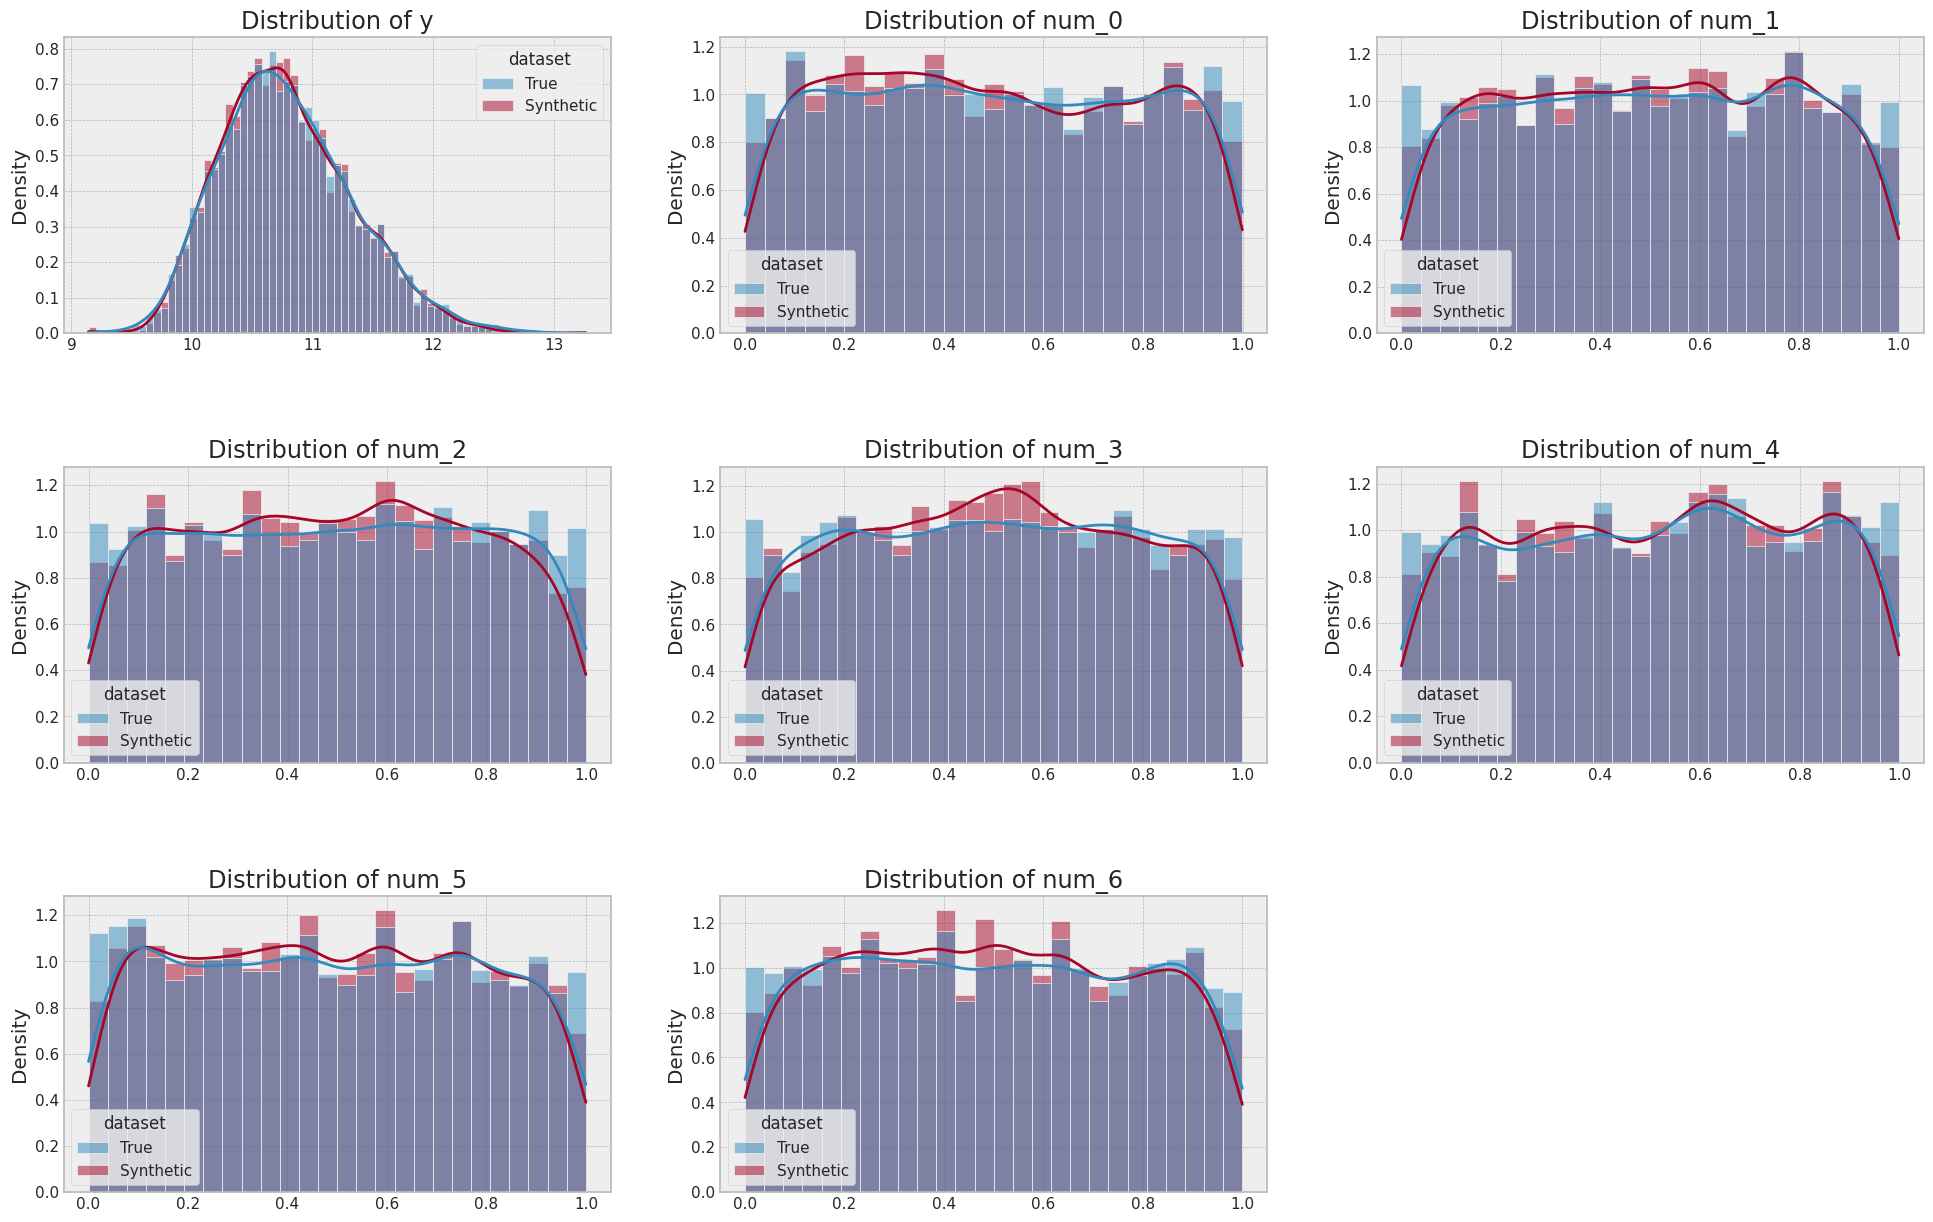

In [35]:
compare_distributions_grid([true_df, synthetic_df], ["True", "Synthetic"], 3, 3)

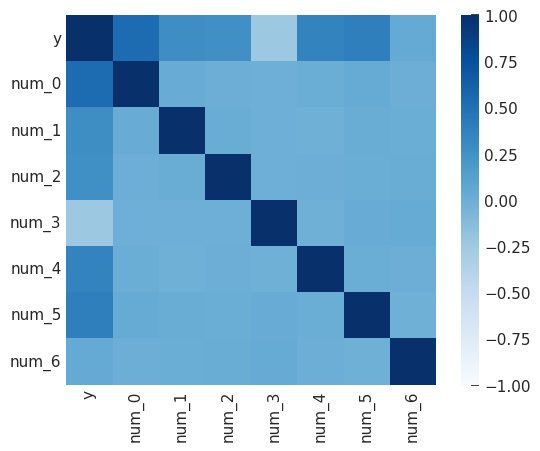

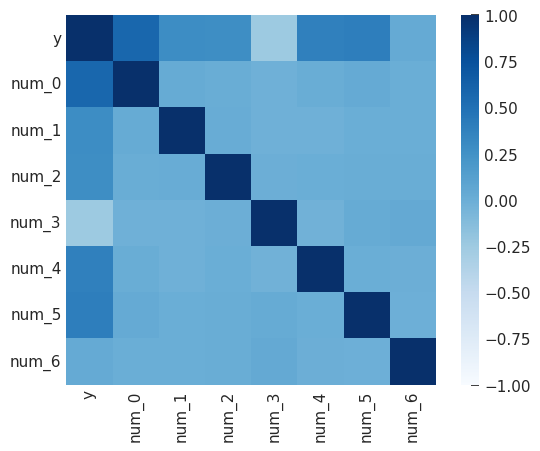

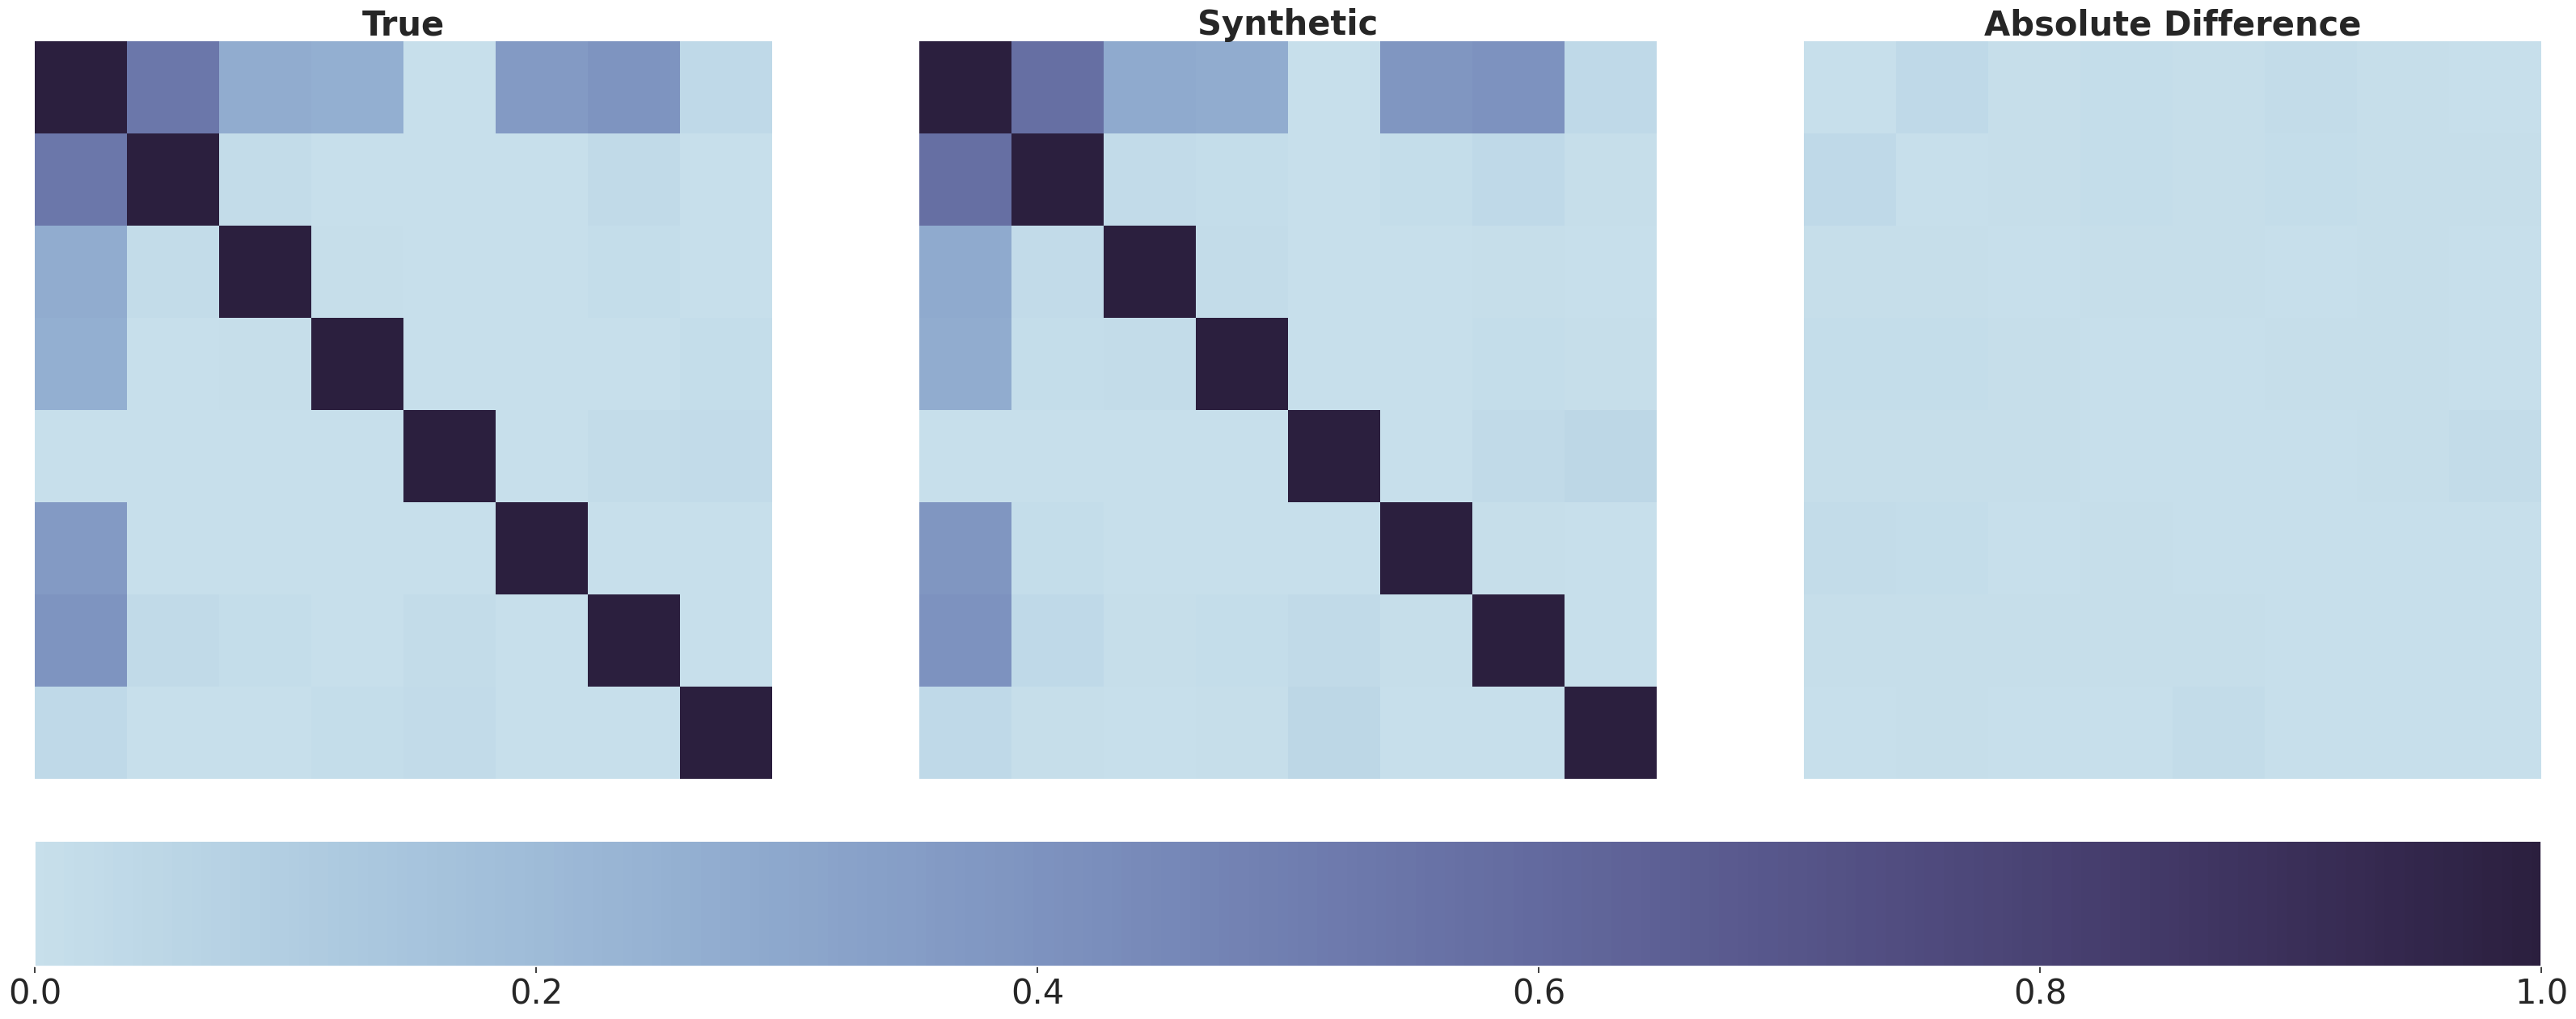

In [36]:
heatmap_correlation(true_df, synthetic_df, "True", "Synthetic")

# Syn-Boosting versus raw training versus Bayes error

Use CatBoost as our regressor.

Bayes error under square error loss: $\sigma^2$

## Regression using raw training data versus pre-training data


In [37]:
num_features_list = [f"num_{i}" for i in range(7)]

train_df = concat_data(raw_data_dir, split="train")
val_df = concat_data(raw_data_dir, split="val")
test_df = concat_data(raw_data_dir, split="test")

In [38]:
raw_model = catboost_pred_model(
    train_df,
    val_df,
    num_features_list=num_features_list,
    iterations=2000,
    loss_function="RMSE",
    verbose=False,
)

test_rmse_raw = test_rmse(raw_model, test_df)
print("Regression using raw training data:")
print("Validation:", raw_model.get_best_score())
print("Test RMSE:", test_rmse_raw)

Regression using raw training data:
Validation: {'learn': {'RMSE': 0.025944904579910427}, 'validation': {'RMSE': 0.23536457909013214}}
Test RMSE: 0.23559376436058052


In [39]:
pretrain_df = concat_data(pretrain_data_dir, split="train")

pretrain_model = catboost_pred_model(
    pretrain_df,
    val_df,
    num_features_list=num_features_list,
    iterations=2000,
    loss_function="RMSE",
    verbose=False,
)

print("Regression using pre-training data:")
print("Validation:", pretrain_model.get_best_score())
print("Test RMSE:", test_rmse(pretrain_model, test_df))

Regression using pre-training data:
Validation: {'learn': {'RMSE': 0.11945534467093588}, 'validation': {'RMSE': 0.20961397465094242}}
Test RMSE: 0.21240341228832305


In [40]:
print("Bayes error (in squre root):", sigma)

Bayes error (in squre root): 0.2


## Syn-Boost tuning

In [41]:
rho_min, rho_max, step_size = 1, 30, 1
rho_list = np.linspace(rho_min, rho_max, int((rho_max - rho_min) / step_size) + 1)

result_dict = {"rhos": rho_list, "scores": []}

for rho in tqdm(rho_list):
    m = int(n_train * rho)

    temp_dir = generate_sample(
        pipeline_config_path=f"./ckpt/{keyword}/config.toml",
        ckpt_path=f"./ckpt/{keyword}/model.pt",
        num_samples=m,
        batch_size=m,
        temp_parent_dir="./temp",
    )

    fake_train_df = concat_data(temp_dir, split="train")

    fake_train_model = catboost_pred_model(
        fake_train_df,
        val_df,
        num_features_list=num_features_list,
        iterations=2000,
        loss_function="RMSE",
        verbose=False,
    )

    score = test_rmse(fake_train_model, test_df)
    result_dict["scores"].append(score)

    pickle.dump(result_dict, open(f"./results/{keyword}.pkl", "wb"))
    print(f"rho = {rho}, m = {m}: Test RMSE is {score}.")

  0%|          | 0/30 [00:00<?, ?it/s]

Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (500, 7)


  3%|▎         | 1/30 [00:04<02:02,  4.22s/it]

rho = 1.0, m = 500: Test RMSE is 0.2344412746904975.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (1000, 7)


  7%|▋         | 2/30 [00:08<02:03,  4.42s/it]

rho = 2.0, m = 1000: Test RMSE is 0.2217856583991526.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (1500, 7)


 10%|█         | 3/30 [00:13<02:05,  4.65s/it]

rho = 3.0, m = 1500: Test RMSE is 0.21824137359903706.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (2000, 7)


 13%|█▎        | 4/30 [00:18<02:06,  4.85s/it]

rho = 4.0, m = 2000: Test RMSE is 0.2157669416223399.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (2500, 7)


 17%|█▋        | 5/30 [00:24<02:07,  5.11s/it]

rho = 5.0, m = 2500: Test RMSE is 0.2132800271452198.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (3000, 7)


 20%|██        | 6/30 [00:29<02:04,  5.20s/it]

rho = 6.0, m = 3000: Test RMSE is 0.21198927260923045.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (3500, 7)


 23%|██▎       | 7/30 [00:35<02:04,  5.43s/it]

rho = 7.0, m = 3500: Test RMSE is 0.211027716010294.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (4000, 7)


 27%|██▋       | 8/30 [00:41<02:03,  5.60s/it]

rho = 8.0, m = 4000: Test RMSE is 0.20990599182831512.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (4500, 7)


 30%|███       | 9/30 [00:47<02:01,  5.81s/it]

rho = 9.0, m = 4500: Test RMSE is 0.21058830789583843.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (5000, 7)


 33%|███▎      | 10/30 [00:54<02:02,  6.10s/it]

rho = 10.0, m = 5000: Test RMSE is 0.21125436286290378.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (5500, 7)


 37%|███▋      | 11/30 [01:01<02:00,  6.35s/it]

rho = 11.0, m = 5500: Test RMSE is 0.21161091929189088.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (6000, 7)


 40%|████      | 12/30 [01:08<01:58,  6.57s/it]

rho = 12.0, m = 6000: Test RMSE is 0.21175514314372354.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (6500, 7)


 43%|████▎     | 13/30 [01:15<01:54,  6.74s/it]

rho = 13.0, m = 6500: Test RMSE is 0.2108693942499492.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (7000, 7)


 47%|████▋     | 14/30 [01:23<01:50,  6.91s/it]

rho = 14.0, m = 7000: Test RMSE is 0.20995699265734344.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (7500, 7)


 50%|█████     | 15/30 [01:30<01:46,  7.07s/it]

rho = 15.0, m = 7500: Test RMSE is 0.21014096761400772.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (8000, 7)


 53%|█████▎    | 16/30 [01:38<01:41,  7.24s/it]

rho = 16.0, m = 8000: Test RMSE is 0.21109623265172825.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (8500, 7)


 57%|█████▋    | 17/30 [01:46<01:37,  7.46s/it]

rho = 17.0, m = 8500: Test RMSE is 0.21093415954490852.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (9000, 7)


 60%|██████    | 18/30 [01:54<01:31,  7.59s/it]

rho = 18.0, m = 9000: Test RMSE is 0.2104207733355827.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (9500, 7)


 63%|██████▎   | 19/30 [02:02<01:25,  7.73s/it]

rho = 19.0, m = 9500: Test RMSE is 0.20969538100437699.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (10000, 7)


 67%|██████▋   | 20/30 [02:10<01:19,  7.97s/it]

rho = 20.0, m = 10000: Test RMSE is 0.21010943230981075.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (10500, 7)


 70%|███████   | 21/30 [02:19<01:14,  8.25s/it]

rho = 21.0, m = 10500: Test RMSE is 0.21145924120907006.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (11000, 7)


 73%|███████▎  | 22/30 [02:28<01:07,  8.45s/it]

rho = 22.0, m = 11000: Test RMSE is 0.21054444023818267.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (11500, 7)


 77%|███████▋  | 23/30 [02:37<01:00,  8.58s/it]

rho = 23.0, m = 11500: Test RMSE is 0.21005631456791782.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (12000, 7)


 80%|████████  | 24/30 [02:46<00:52,  8.73s/it]

rho = 24.0, m = 12000: Test RMSE is 0.21112439585661424.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (12500, 7)


 83%|████████▎ | 25/30 [02:55<00:43,  8.80s/it]

rho = 25.0, m = 12500: Test RMSE is 0.2109619512965184.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (13000, 7)


 87%|████████▋ | 26/30 [03:04<00:35,  8.85s/it]

rho = 26.0, m = 13000: Test RMSE is 0.21106891174628148.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (13500, 7)


 90%|█████████ | 27/30 [03:13<00:26,  8.88s/it]

rho = 27.0, m = 13500: Test RMSE is 0.2105637774116761.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (14000, 7)


 93%|█████████▎| 28/30 [03:22<00:17,  8.99s/it]

rho = 28.0, m = 14000: Test RMSE is 0.21181095054911417.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (14500, 7)


 97%|█████████▋| 29/30 [03:32<00:09,  9.13s/it]

rho = 29.0, m = 14500: Test RMSE is 0.2104952395097291.
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (15000, 7)


100%|██████████| 30/30 [03:41<00:00,  7.39s/it]

rho = 30.0, m = 15000: Test RMSE is 0.20981993014011716.


Text(0.0, 1.03, '$n_h$ = 5000')

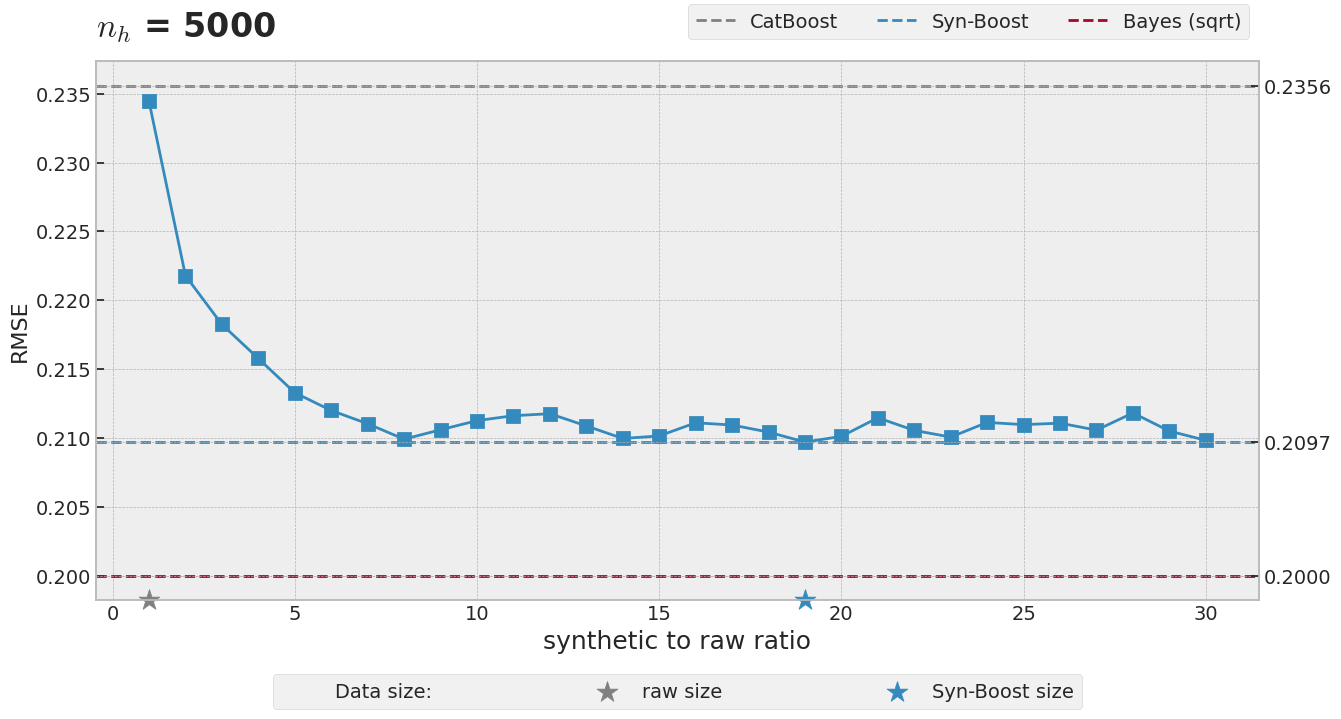

In [42]:
result_dict = pickle.load(open(f"./results/{keyword}.pkl", "rb"))


plt.style.use("bmh")


fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    result_dict["rhos"],
    result_dict["scores"],
    marker="s",
    mew=2,
    linestyle="-",
    markersize=8,
    linewidth=2,
)


raw_size = 1
syngen_size = result_dict["rhos"][np.argmin(result_dict["scores"])]

base_line_value = test_rmse_raw
tuned_value = min(result_dict["scores"])
bayes_value = sigma

y_min, y_max = ax.get_ylim()
y_min = min(base_line_value, min(result_dict["scores"]), bayes_value)
y_max = max(base_line_value, max(result_dict["scores"]), bayes_value)
y_min, y_max = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
marker_kargs = {
    "y": y_min,
    "marker": "*",
    "zorder": 10,
    "clip_on": False,
    "s": 250,
}

size_1 = ax.scatter(x=raw_size, color="grey", label="raw size", **marker_kargs)
size_3 = ax.scatter(x=syngen_size, color="C0", label="Syn-Boost size", **marker_kargs)

ax.set_ylim(y_min, y_max)


error_1 = ax.axhline(base_line_value, linestyle="--", color="grey", label="CatBoost")
error_2 = ax.axhline(tuned_value, linestyle="--", color="C0", label="Syn-Boost")
error_bayes = ax.axhline(bayes_value, linestyle="--", color="C1", label="Bayes (sqrt)")

ax2 = ax.twinx()
ax2.set_yticks([base_line_value, tuned_value, bayes_value])

ax.tick_params(axis="both", which="major", labelsize=14)
ax2.set_ylim(ax.get_ylim())
ax2.tick_params(axis="both", which="major", labelsize=14)


first_legend = plt.legend(
    handles=[error_1, error_2, error_bayes],
    loc="upper right",
    fontsize=14,
    ncol=3,
    bbox_to_anchor=[1, 1.123],
)

plt.gca().add_artist(first_legend)

size_title = plt.plot([], marker="", ls="")[0]
plt.legend(
    handles=[size_title, size_1, size_3],
    loc="upper center",
    bbox_to_anchor=[0.5, -0.12],
    ncol=4,
    fontsize=14,
    columnspacing=8,
    labels=["Data size:", "raw size", "Syn-Boost size"],
)


ax.set_xlabel("synthetic to raw ratio", fontsize=18)
ax.set_ylabel("RMSE", fontsize=16)
ax.set_title(
    f"$n_h$ = {n_pretrain}",
    weight="bold",
    fontsize=24,
    loc="left",
    y=1.03,
)

## Evaluation

In [39]:
result_dict_1000 = pickle.load(open(f"./results/reg_1000.pkl", "rb"))
result_dict_2000 = pickle.load(open(f"./results/reg_2000.pkl", "rb"))
result_dict_5000 = pickle.load(open(f"./results/reg_5000.pkl", "rb"))
result_dict_20000 = pickle.load(open(f"./results/reg_20000.pkl", "rb"))


print(np.min(result_dict_1000["scores"]))
print(np.min(result_dict_2000["scores"]))
print(np.min(result_dict_5000["scores"]))
print(np.min(result_dict_20000["scores"]))

0.2195365566093024
0.21106771057210147
0.20619219125232804
0.20299674302855705


### Effect of generation error on accuracy

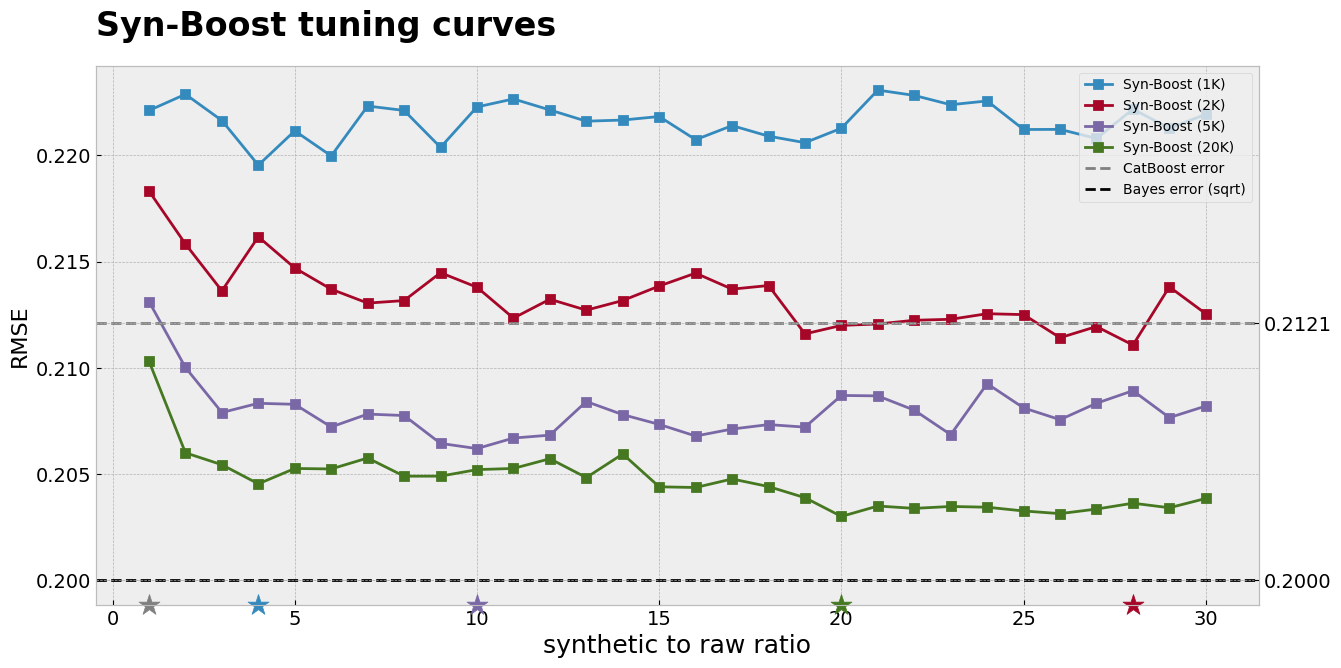

In [47]:
plt.style.use("bmh")


fig, ax = plt.subplots(figsize=(15, 7))

scatter_kargs = {
    "marker": "s",
    "mew": 2,
    "markersize": 6,
    "linestyle": "-",
    "linewidth": 2,
}

ax.plot(
    result_dict_1000["rhos"],
    result_dict_1000["scores"],
    label="Syn-Boost (1K)",
    **scatter_kargs,
)

ax.plot(
    result_dict_2000["rhos"],
    result_dict_2000["scores"],
    label="Syn-Boost (2K)",
    **scatter_kargs,
)

ax.plot(
    result_dict_5000["rhos"],
    result_dict_5000["scores"],
    label="Syn-Boost (5K)",
    **scatter_kargs,
)
ax.plot(
    result_dict_20000["rhos"],
    result_dict_20000["scores"],
    label="Syn-Boost (20K)",
    **scatter_kargs,
)

# data sizes to be marked
raw_size = 1
syngen_size_1000 = result_dict_1000["rhos"][np.argmin(result_dict_1000["scores"])]
syngen_size_2000 = result_dict_2000["rhos"][np.argmin(result_dict_2000["scores"])]
syngen_size_5000 = result_dict_5000["rhos"][np.argmin(result_dict_5000["scores"])]
syngen_size_20000 = result_dict_20000["rhos"][np.argmin(result_dict_20000["scores"])]

# values to be marked
base_line_value = test_rmse_raw
bayes_value = sigma

y_min, y_max = ax.get_ylim()
y_min = min(
    base_line_value,
    bayes_value,
    min(result_dict_1000["scores"]),
    min(result_dict_2000["scores"]),
    min(result_dict_5000["scores"]),
    min(result_dict_20000["scores"]),
)
y_max = max(
    base_line_value,
    bayes_value,
    max(result_dict_1000["scores"]),
    max(result_dict_2000["scores"]),
    max(result_dict_5000["scores"]),
    max(result_dict_20000["scores"]),
)
y_min, y_max = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
marker_kargs = {
    "y": y_min,
    "marker": "*",
    "zorder": 10,
    "clip_on": False,
    "s": 250,
}

handle_raw = ax.scatter(x=raw_size, color="grey", **marker_kargs)
handle_syngen_1000 = ax.scatter(x=syngen_size_1000, color="C0", **marker_kargs)
handle_syngen_2000 = ax.scatter(x=syngen_size_2000, color="C1", **marker_kargs)
handle_syngen_5000 = ax.scatter(x=syngen_size_5000, color="C2", **marker_kargs)
handle_syngen_20000 = ax.scatter(x=syngen_size_20000, color="C3", **marker_kargs)

ax.set_ylim(y_min, y_max)


error_raw = ax.axhline(
    base_line_value, linestyle="--", color="grey", label="CatBoost error"
)
error_bayes = ax.axhline(
    bayes_value, linestyle="--", color="black", label="Bayes error (sqrt)"
)

ax2 = ax.twinx()
ax2.set_yticks([base_line_value, bayes_value])

ax.tick_params(axis="both", which="major", labelsize=14)
ax2.set_ylim(ax.get_ylim())
ax2.tick_params(axis="both", which="major", labelsize=14)


ax.set_xlabel("synthetic to raw ratio", fontsize=18)
ax.set_ylabel("RMSE", fontsize=16)
ax.set_title(
    "Syn-Boost tuning curves",
    weight="bold",
    fontsize=24,
    loc="left",
    y=1.04,
)

ax.legend(loc="upper right")

plt.show()

### Table evaluation results

Make a table as supplement to the tuning curves with columns: holdout size, generation error, optimal size, optimal RMSE, distance metric, raw error, Bayes error

In [10]:
keyword_list = [
    "reg_1000",
    "reg_1000_finetuned",
    "reg_5000",
    "reg_5000_finetuned",
]

In [15]:
n = 10000

df_processed_list = []
for keyword in keyword_list:
    print(f"Generating synthetic data for {keyword} ...")
    temp_dir = generate_sample(
        pipeline_config_path=f"./ckpt/{keyword}/config.toml",
        ckpt_path=f"./ckpt/{keyword}/model.pt",
        num_samples=n,
        batch_size=n,
        temp_parent_dir="./temp",
    )

    synthetic_df = concat_data(temp_dir, split="train")
    synthetic_df_processed = pd.DataFrame(
        quantile_transform(
            synthetic_df, output_distribution="uniform", random_state=SEED
        )
    )
    df_processed_list.append(synthetic_df_processed)

# print("Preparing evaluation data ...")
# eval_df = concat_data(raw_data_dir, split="test")
# eval_df_processed = pd.DataFrame(
#     quantile_transform(eval_df, output_distribution="uniform", random_state=SEED)
# )
# print(eval_df_processed.shape)

print("Preparing true data ...")
np.random.seed(SEED)
X, y = true_sampler.sample(n)
true_df = pd.DataFrame(
    np.concatenate([y.reshape(-1, 1), X], axis=1),
    columns=["y"] + [f"num_{i}" for i in range(X.shape[1])],
)
true_df_processed = pd.DataFrame(
    quantile_transform(true_df, output_distribution="uniform", random_state=SEED)
)

Generating synthetic data for reg_1000 ...
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (50000, 7)
Generating synthetic data for reg_1000_finetuned ...
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (50000, 7)
Generating synthetic data for reg_5000 ...
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (50000, 7)
Generating synthetic data for reg_5000_finetuned ...
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (50000, 7)
Preparing true data ...
X shape:  (50000, 7)
y shape:  (50000,)


In [12]:


distance_list = []
for kw, df_processed in zip(keyword_list, df_processed_list):
    w2_distance = wasserstein_2_distance(df_processed, true_df_processed)
    distance_list.append(w2_distance)

    print(kw, ":", w2_distance)

pd.DataFrame(
    distance_list,
    index=keyword_list,
    columns=["2-Wasserstein"],
)

reg_1000 : 0.3511645277314752
reg_1000_finetuned : 0.29734926787992705
reg_5000 : 0.2858469856917521
reg_5000_finetuned : 0.2807825115512812


,2-Wasserstein
reg_1000,0.351165
reg_1000_finetuned,0.297349
reg_5000,0.285847
reg_5000_finetuned,0.280783


In [9]:
for keyword in keyword_list:
    result_dict = pickle.load(open(f"./results/{keyword}.pkl", "rb"))
    print(
        keyword,
        ":",
        result_dict["rhos"][np.argmin(result_dict["scores"])],
        np.min(result_dict["scores"]),
    )

reg_1000 : 7.0 0.22524733677711348
reg_1000_finetuned : 28.0 0.21773674422083772
reg_5000 : 19.0 0.20969538100437699
reg_5000_finetuned : 27.0 0.20781009282685645


# Additional stuff

## Fine-tune the bad pre-trained models

In [43]:
keyword = "reg_5000"
ckpt_dir = f"./ckpt/{keyword}"

In [66]:
# setup 1: 2000 + 1000 + 1000
# reg_1000_finetuned: steps=50000, lr is as default (leave blank)
# reg_2000_finetuned: steps=30000, lr=3e-4

# setup 2: 500 + 200 + 1000
# reg_1000_finetuned: steps=1000, lr=3e-4
# reg_5000_finetuned: steps=1000, lr=3e-6
train_tabddpm(
    pipeline_config_path=os.path.join(ckpt_dir, "config.toml"),
    real_data_dir=raw_data_dir,
    ckpt_path=os.path.join(ckpt_dir, "model.pt"),
    pipeline_dict_path=os.path.join(ckpt_dir, "pipeline_dict.joblib"),
    steps=1000,
    lr=3e-6,
    temp_parent_dir=f"./ckpt/{keyword}_finetuned",
    device="cuda:0",
)

Loading numerical preprocessing pipeline from ./ckpt/reg_5000/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
8
{'d_in': 8, 'num_classes': 0, 'is_y_cond': False, 'rtdl_params': {'d_layers': [512, 256, 256, 256, 256, 128], 'dropout': 0.0}}
mlp
Loading model checkpoint from ./ckpt/reg_5000/model.pt
Step 500/1000 MLoss: 0.0 GLoss: 0.5429 Sum: 0.5429
Step 1000/1000 MLoss: 0.0 GLoss: 0.524 Sum: 0.524


'./ckpt/reg_5000_finetuned'

In [67]:
rho_min, rho_max, step_size = 1, 30, 1
rho_list = np.linspace(rho_min, rho_max, int((rho_max - rho_min) / step_size) + 1)

result_dict = {"rhos": rho_list, "scores": []}

for rho in tqdm(rho_list):
    m = int(n_train * rho)

    temp_dir = generate_sample(
        pipeline_config_path=f"./ckpt/{keyword}_finetuned/config.toml",
        ckpt_path=f"./ckpt/{keyword}_finetuned/model.pt",
        pipeline_dict_path=f"./ckpt/{keyword}_finetuned/pipeline_dict.joblib",
        num_samples=m,
        batch_size=m,
        temp_parent_dir="./temp",
    )

    fake_train_df = concat_data(temp_dir, split="train")

    fake_train_model = catboost_pred_model(
        fake_train_df,
        val_df,
        num_features_list=num_features_list,
        iterations=2000,
        loss_function="RMSE",
        verbose=False,
    )

    score = test_rmse(fake_train_model, test_df)
    result_dict["scores"].append(score)

    pickle.dump(result_dict, open(f"./results/{keyword}_finetuned.pkl", "wb"))
    print(f"rho = {rho}, m = {m}: Test RMSE is {score}.")

  0%|          | 0/30 [00:00<?, ?it/s]

Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (500, 7)


  3%|▎         | 1/30 [00:04<01:56,  4.01s/it]re than one logger at same time is not thread safe.

rho = 1.0, m = 500: Test RMSE is 0.23805097108329354.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (1000, 7)


  7%|▋         | 2/30 [00:08<01:58,  4.24s/it]

rho = 2.0, m = 1000: Test RMSE is 0.2225986154685004.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (1500, 7)


 10%|█         | 3/30 [00:13<02:01,  4.49s/it]

rho = 3.0, m = 1500: Test RMSE is 0.22085387339325085.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (2000, 7)


 13%|█▎        | 4/30 [00:18<02:00,  4.64s/it]

rho = 4.0, m = 2000: Test RMSE is 0.21770435538448007.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (2500, 7)


 17%|█▋        | 5/30 [00:23<02:02,  4.90s/it]

rho = 5.0, m = 2500: Test RMSE is 0.2151668402732875.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (3000, 7)


 20%|██        | 6/30 [00:28<02:02,  5.09s/it]

rho = 6.0, m = 3000: Test RMSE is 0.21296505159399526.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (3500, 7)


 23%|██▎       | 7/30 [00:34<02:00,  5.26s/it]

rho = 7.0, m = 3500: Test RMSE is 0.21253499316342014.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (4000, 7)


 27%|██▋       | 8/30 [00:40<01:58,  5.37s/it]

rho = 8.0, m = 4000: Test RMSE is 0.2114566695196179.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (4500, 7)


 30%|███       | 9/30 [00:46<01:57,  5.58s/it]

rho = 9.0, m = 4500: Test RMSE is 0.2105024785163695.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (5000, 7)


 33%|███▎      | 10/30 [00:52<01:56,  5.82s/it]

rho = 10.0, m = 5000: Test RMSE is 0.21214649318696255.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (5500, 7)


 37%|███▋      | 11/30 [00:59<01:55,  6.09s/it]

rho = 11.0, m = 5500: Test RMSE is 0.21147485349811318.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (6000, 7)


 40%|████      | 12/30 [01:06<01:53,  6.32s/it]

rho = 12.0, m = 6000: Test RMSE is 0.2108956283567303.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (6500, 7)


 43%|████▎     | 13/30 [01:12<01:50,  6.49s/it]

rho = 13.0, m = 6500: Test RMSE is 0.2109518730284167.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (7000, 7)


 47%|████▋     | 14/30 [01:19<01:46,  6.64s/it]

rho = 14.0, m = 7000: Test RMSE is 0.21127996054017104.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (7500, 7)


 50%|█████     | 15/30 [01:27<01:42,  6.83s/it]

rho = 15.0, m = 7500: Test RMSE is 0.21009990171708032.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (8000, 7)


 53%|█████▎    | 16/30 [01:34<01:37,  6.97s/it]

rho = 16.0, m = 8000: Test RMSE is 0.21020030305830215.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (8500, 7)


 57%|█████▋    | 17/30 [01:41<01:32,  7.11s/it]

rho = 17.0, m = 8500: Test RMSE is 0.21045630965462175.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (9000, 7)


 60%|██████    | 18/30 [01:49<01:27,  7.29s/it]

rho = 18.0, m = 9000: Test RMSE is 0.210279687099459.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (9500, 7)


 63%|██████▎   | 19/30 [01:57<01:22,  7.47s/it]

rho = 19.0, m = 9500: Test RMSE is 0.21071955856056068.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (10000, 7)


 67%|██████▋   | 20/30 [02:05<01:17,  7.71s/it]

rho = 20.0, m = 10000: Test RMSE is 0.21030498707791215.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (10500, 7)


 70%|███████   | 21/30 [02:14<01:11,  7.90s/it]

rho = 21.0, m = 10500: Test RMSE is 0.2105121831717052.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (11000, 7)


 73%|███████▎  | 22/30 [02:22<01:04,  8.04s/it]

rho = 22.0, m = 11000: Test RMSE is 0.20977430110513384.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (11500, 7)


 77%|███████▋  | 23/30 [02:30<00:57,  8.17s/it]

rho = 23.0, m = 11500: Test RMSE is 0.21060262410645222.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (12000, 7)


 80%|████████  | 24/30 [02:39<00:49,  8.30s/it]

rho = 24.0, m = 12000: Test RMSE is 0.20918960943813109.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (12500, 7)


 83%|████████▎ | 25/30 [02:48<00:42,  8.47s/it]

rho = 25.0, m = 12500: Test RMSE is 0.20922943792611925.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (13000, 7)


 87%|████████▋ | 26/30 [02:57<00:34,  8.53s/it]

rho = 26.0, m = 13000: Test RMSE is 0.20912857634674134.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (13500, 7)


 90%|█████████ | 27/30 [03:06<00:25,  8.66s/it]

rho = 27.0, m = 13500: Test RMSE is 0.20781009282685645.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (14000, 7)


 93%|█████████▎| 28/30 [03:15<00:17,  8.82s/it]

rho = 28.0, m = 14000: Test RMSE is 0.20936244448390923.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (14500, 7)


 97%|█████████▋| 29/30 [03:24<00:08,  9.00s/it]

rho = 29.0, m = 14500: Test RMSE is 0.2097907185140745.
Loading numerical preprocessing pipeline from ./ckpt/reg_5000_finetuned/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (15000, 7)


100%|██████████| 30/30 [03:33<00:00,  7.13s/it]

rho = 30.0, m = 15000: Test RMSE is 0.2092667385538091.


## Evaluation before/after fine-tuning

In [68]:
keyword_small_size = 1000
keyword_large_size = 5000

result_small= pickle.load(open(f"./results/reg_{keyword_small_size}.pkl", "rb"))
result_small_finetuned = pickle.load(open(f"./results/reg_{keyword_small_size}_finetuned.pkl", "rb"))
result_large = pickle.load(open(f"./results/reg_{keyword_large_size}.pkl", "rb"))
result_large_finetuned = pickle.load(open(f"./results/reg_{keyword_large_size}_finetuned.pkl", "rb"))

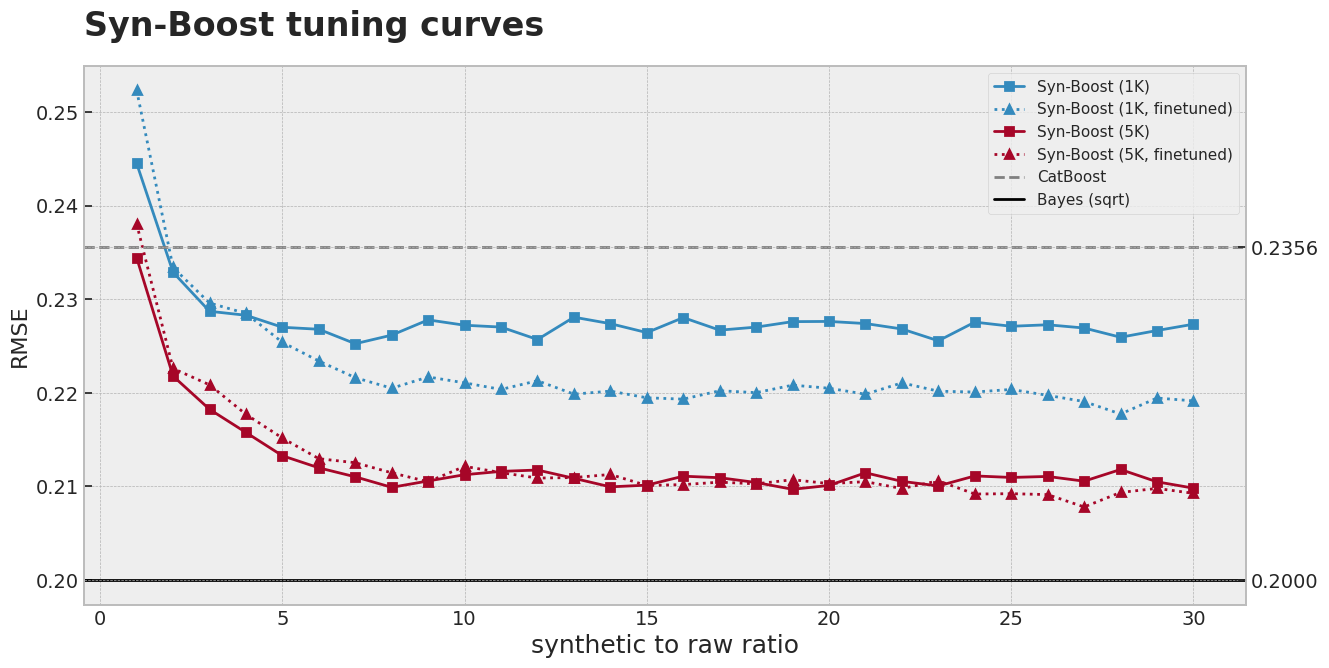

In [71]:
plt.style.use("bmh")


fig, ax = plt.subplots(figsize=(15, 7))

scatter_kargs = {
    "mew": 2,
    "markersize": 6,
    "linewidth": 2,
}

ax.plot(
    result_small["rhos"],
    result_small["scores"],
    color="C0",
    marker="s",
    linestyle="-",
    label=f"Syn-Boost ({round(keyword_small_size/1000)}K)",
    **scatter_kargs,
)

ax.plot(
    result_small_finetuned["rhos"],
    result_small_finetuned["scores"],
    color="C0",
    marker="^",
    linestyle=":",
    label=f"Syn-Boost ({round(keyword_small_size/1000)}K, finetuned)",
    **scatter_kargs,
)

ax.plot(
    result_large["rhos"],
    result_large["scores"],
    color="C1",
    marker="s",
    linestyle="-",
    label=f"Syn-Boost ({round(keyword_large_size/1000)}K)",
    **scatter_kargs,
)

ax.plot(
    result_large_finetuned["rhos"],
    result_large_finetuned["scores"],
    color="C1",
    marker="^",
    linestyle=":",
    label=f"Syn-Boost ({round(keyword_large_size/1000)}K, finetuned)",
    **scatter_kargs,
)


base_line_value = test_rmse_raw
bayes_value = sigma

y_min, y_max = ax.get_ylim()
y_min = min(
    base_line_value,
    bayes_value,
    min(result_small["scores"]),
    min(result_small_finetuned["scores"]),
    min(result_large["scores"]),
    min(result_large_finetuned["scores"]),
)
y_max = max(
    base_line_value,
    bayes_value,
    max(result_small["scores"]),
    max(result_small_finetuned["scores"]),
    max(result_large["scores"]),
    max(result_large_finetuned["scores"]),
)
y_min, y_max = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
ax.set_ylim(y_min, y_max)

ax2 = ax.twinx()
ax2.set_yticks([base_line_value, bayes_value])

ax.tick_params(axis="both", which="major", labelsize=14)
ax2.set_ylim(ax.get_ylim())
ax2.tick_params(axis="both", which="major", labelsize=14)


ax.axhline(base_line_value, linestyle="--", color="grey", label="CatBoost")
ax.axhline(bayes_value, linestyle="-", color="black", label="Bayes (sqrt)")


ax.set_xlabel("synthetic to raw ratio", fontsize=18)
ax.set_ylabel("RMSE", fontsize=16)
ax.set_title(
    "Syn-Boost tuning curves",
    weight="bold",
    fontsize=24,
    loc="left",
    y=1.04,
)

ax.legend()

plt.show()